In [1]:
# importar bibliotecas
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import time
import warnings
warnings.filterwarnings("ignore")


#### 1 - carregar base tratada

In [2]:
# Verifica a pasta corrente
pasta = os.getcwd()

In [3]:
pasta_resultados = os.path.join(pasta, "resultados")
pasta_graficos = os.path.join(pasta, "graficos")

In [4]:
# Regex notation by "\s+". This means a single space, or multiple spaces are all to be treated as a single separator.
df_dados = pd.read_csv(os.path.join(pasta, "dados") + "/" + 'bltper_1x1.txt', skiprows=2, sep = '\s+') 

In [5]:
df_dados.head().append(df_dados.tail())

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,1933,0,0.06129,0.05861,0.25,100000,5861,95624,6089609,60.90
1,1933,1,0.00946,0.00941,0.50,94139,886,93696,5993985,63.67
2,1933,2,0.00435,0.00434,0.50,93253,405,93050,5900289,63.27
3,1933,3,0.00310,0.00310,0.50,92848,288,92704,5807239,62.55
4,1933,4,0.00239,0.00238,0.50,92560,221,92450,5714535,61.74
9652,2019,106,0.51164,0.40742,0.50,272,111,216,497,1.83
9653,2019,107,0.54239,0.42668,0.50,161,69,127,281,1.75
9654,2019,108,0.57289,0.44533,0.50,92,41,72,154,1.67
9655,2019,109,0.60292,0.46327,0.50,51,24,39,83,1.62
9656,2019,110+,0.63226,1.00000,1.58,27,27,43,43,1.58


In [6]:
# Tratamento da idade 110+ para os anos.
# DataFrame.loc[condition, column_name] = new_value
df_dados.loc[(df_dados.Age == '110+'),'Age'] = 110

#### 2 - criar features, entre elas a logqx, que corresponde já convertido a escala logarítma da probabilidade de morte

In [7]:
# Criar a feature log qx
df_dados['logqx'] = np.log(df_dados['qx'])
# Aproveitar e corrigir a tipagem da feature Age
df_dados["Age"] = df_dados["Age"].astype(int)

In [8]:
df_dados.head().append(df_dados.tail())

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex,logqx
0,1933,0,0.06129,0.05861,0.25,100000,5861,95624,6089609,60.90,-2.836850
1,1933,1,0.00946,0.00941,0.50,94139,886,93696,5993985,63.67,-4.665982
2,1933,2,0.00435,0.00434,0.50,93253,405,93050,5900289,63.27,-5.439881
3,1933,3,0.00310,0.00310,0.50,92848,288,92704,5807239,62.55,-5.776353
4,1933,4,0.00239,0.00238,0.50,92560,221,92450,5714535,61.74,-6.040655
9652,2019,106,0.51164,0.40742,0.50,272,111,216,497,1.83,-0.897911
9653,2019,107,0.54239,0.42668,0.50,161,69,127,281,1.75,-0.851721
9654,2019,108,0.57289,0.44533,0.50,92,41,72,154,1.67,-0.808940
9655,2019,109,0.60292,0.46327,0.50,51,24,39,83,1.62,-0.769445
9656,2019,110,0.63226,1.00000,1.58,27,27,43,43,1.58,0.000000


In [9]:
df_dados.shape

(9657, 11)

#### 3 - Criar a feature tempo t, com base na feature ano, que corresponde ao elemento temporal da série

In [10]:
# Preparar dataset
#serie = {'t': ano, 'logqx_prob': logqx_prob}
df_lstm = pd.DataFrame(df_dados, columns=['Age','Year','logqx'])
df_lstm['t'] = pd.to_datetime(df_lstm['Year'], format='%Y')
#df_lstm.drop(['ano'], axis=1, inplace=True)
df_lstm.set_index('t', inplace=True)


In [11]:
#df_lstm[df_lstm['t'].dt.year == 1998]
df_lstm.head().append(df_lstm.tail())

,Age,Year,logqx
t,,,
1933-01-01,0,1933,-2.836850
1933-01-01,1,1933,-4.665982
1933-01-01,2,1933,-5.439881
1933-01-01,3,1933,-5.776353
1933-01-01,4,1933,-6.040655
2019-01-01,106,2019,-0.897911
2019-01-01,107,2019,-0.851721
2019-01-01,108,2019,-0.808940
2019-01-01,109,2019,-0.769445


In [12]:
df_lstm[df_lstm['Age']==0]

,Age,Year,logqx
t,,,
1933-01-01,0,1933,-2.836850
1934-01-01,0,1934,-2.729376
1935-01-01,0,1935,-2.833443
1936-01-01,0,1936,-2.813744
1937-01-01,0,1937,-2.837191
...,...,...,...
2015-01-01,0,2015,-5.137901
2016-01-01,0,2016,-5.144738
2017-01-01,0,2017,-5.165536


#### 4 - Separar a base em base de treino e base de teste para cada idade x ao longo dos anos t, ou seja, para a idade 0, entre os anos 1998 a 2018, para a idade 1, no mesmo período e assim por diante.

##### Rotina LSTM, métricas e gráficos

Epoch 1/5
27/27 [==============================] - 1s 38ms/step - loss: 0.0343 - mae: 0.1316
Epoch 2/5
27/27 [==============================] - 1s 38ms/step - loss: 0.0059 - mae: 0.0605
Epoch 3/5
27/27 [==============================] - 1s 42ms/step - loss: 0.0059 - mae: 0.0535
Epoch 4/5
27/27 [==============================] - 1s 43ms/step - loss: 0.0021 - mae: 0.0331
Epoch 5/5
27/27 [==============================] - 1s 42ms/step - loss: 0.0031 - mae: 0.0406
idade: 0 rmse:  [0.24470371]
Epoch 1/5
29/29 [==============================] - 1s 32ms/step - loss: 0.0044 - mae: 0.0459
Epoch 2/5
29/29 [==============================] - 1s 33ms/step - loss: 0.0067 - mae: 0.0630
Epoch 3/5
29/29 [==============================] - 1s 33ms/step - loss: 0.0025 - mae: 0.0320
Epoch 4/5
29/29 [==============================] - 1s 31ms/step - loss: 0.0027 - mae: 0.0365
Epoch 5/5
29/29 [==============================] - 1s 29ms/step - loss: 0.0020 - mae: 0.0333
Epoch 1/5
27/27 [========================

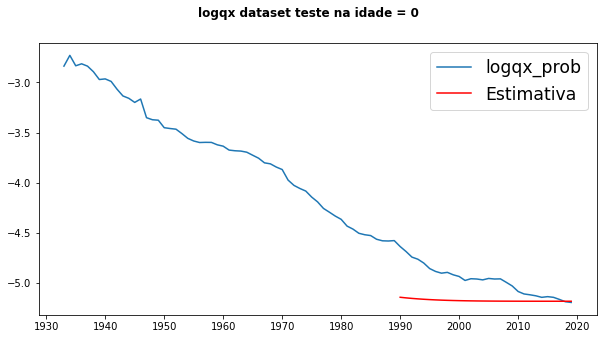

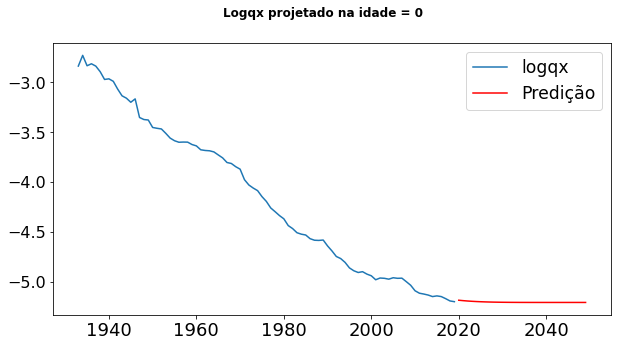

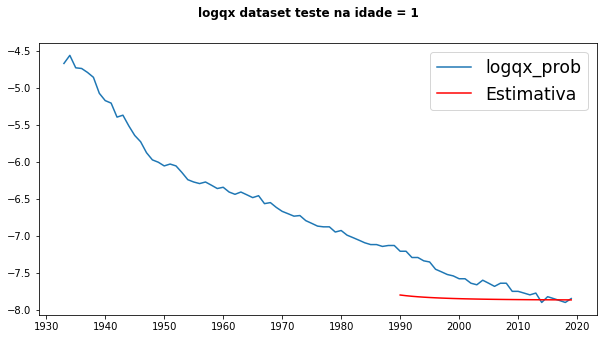

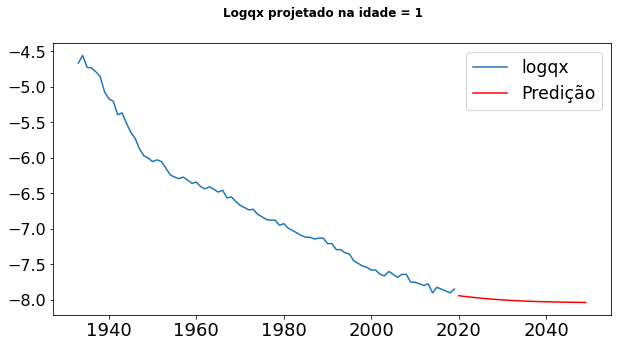

In [21]:
# proximos testes: n_epochs = 1000 e base teste de 30 anos. Sugestão. No programa em script. 
# Usar, também, o código para salvar o log do compilie
predict_res = []
pred_actual_rmse_res = []

w_max = max(df_dados['Age']) # definir maior idade nas tábuas. testes: 3

# inicio do cronometro do processamento
start = time.time()

n_input = 30 # 10 # Length of the output sequences (in number of timesteps). Corresponde ao número de dados 
# que usaremos para a rede. No caso, 10 anos na idade = 0, 10 anos na idade=1, etc.Vamos testar com 3 anos??
n_features = 1 # Número de features, variáveis. O modelo é univariavel (qx) para cada idade.
n_epochs = 500 # 1000 #500
n_batch = 2  # Number of timeseries samples in each batch (except maybe the last one).
n_neurons = 50
t_projecao = 30
# (#batch_size,#inputs,#features) 3D
for x in range(0, w_max+1):  
    
    # Série para cada idade ao longo dos anos de 1933 a 2019
    #serie = df_lstm[df_lstm['idade']==x]['logqx_prob']
    serie = df_lstm[df_lstm['Age']==x]
    serie.drop(['Age', 'Year'], axis=1, inplace=True)

    # Separar base de treino e teste === preparar dados
    treino, teste = serie[:-30], serie[-30:]
    
    # Padronizar dados: Normalizar entre 0 e 1
    scaler = MinMaxScaler()
    scaler.fit(treino)
    treino = scaler.transform(treino)
    teste = scaler.transform(teste)
    
    #generator = TimeseriesGenerator(treino, treino, length=n_input, batch_size=n_batch)
    # length: The number of lag observations to use in the input portion of each sample (e.g. 3)
    # That is the desired number of lag observations to use as input = VAmos tentar 21: 2018-1998
    
    # batch_size: The number of samples to return on each iteration (e.g. 32)
    # The samples are not shuffled by default. This is useful for some recurrent neural networks
    # like LSTMs that maintain state across samples within a batch.
    # both the data and target for this generator is “treino”.
    
    generator = TimeseriesGenerator(treino, treino, length=n_input, batch_size=n_batch)
    
    # ============================ CAMADAS =========== CAMADAS =================================
    # A camada LSTM já possui, em sua construção, funções default de ativação:
    # activation="tanh",recurrent_activation="sigmoid",
    # três funções sigmoide e 1 tangente hiperbólica
    
    model = Sequential()
    
    # #reshape the data into LSTM required (#batch,#timesteps,#features)
    #Adding the first LSTM layer and some Dropout regularisation
    
    model.add(LSTM(n_neurons, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
    #model.add(LSTM(n_neurons, activation='relu', input_shape=(n_input, n_features)))
    # Para manter o mesmo padrão da simulação da rede Neural Bi-direcional, vou manter somente uma camada de dropout
    # model.add(Dropout(0.20))
    
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(n_neurons))
    model.add(Dropout(0.20))
    
    # Adding a third LSTM layer and some Dropout regularisation
    #model.add(LSTM(n_neurons, return_sequences=True))
    #model.add(Dropout(0.20))

    # Adding a fourth LSTM layer and some Dropout regularisation
    #model.add(LSTM(n_neurons))
    #model.add(Dropout(0.20))
    
    # Adding the output layer
    model.add(Dense(1))
    
    # ============================ CAMADAS =========== CAMADAS =================================
    
    #model.add(Dense(y.shape[1], activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=["mae"])
    
    
    # fit model
    #model.fit_generator(generator, epochs=n_epochs)
    # ADAPTADO PARA A ATUALIZAÇÃO DO KERAS (28/11/2020)
    csv_logger = CSVLogger('log_modelo_demography.csv', append=True, separator=';')
    model.fit(generator, epochs=n_epochs, callbacks=[csv_logger])
    # model.fit(X_train, Y_train, callbacks=[csv_logger])
    
    #Previsão
    pred_list = []
    batch = treino[-n_input:].reshape((1, n_input, n_features))

    for i in range(n_input):  # n_input
        pred_list.append(model.predict(batch)[0])
        batch = np.append(batch[:,1:,:], [[pred_list[i]]], axis=1)

    #inverse transform forecasts and test. Need to scale them back so we can compare the final results
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), 
                            index=serie[-n_input:].index, columns=['Prediction'])
    
    df_teste = pd.concat([serie, df_predict], axis=1)

    # Gráfico da estimativa, com a base de teste
    #plt.figure(figsize=(10,5))
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111) # "111" means "1x1 grid, first subplot" 
    ax.plot(df_teste.index, df_teste['logqx'])
    ax.plot(df_teste.index, df_teste['Prediction'], color='r')
    #ax.legend(loc='best', fontsize='xx-large')
    ax.legend(loc='best', fontsize='xx-large', labels=['logqx_prob', 'Estimativa'])
    fig.suptitle('logqx dataset teste na idade = %i' %x, fontweight="bold") # Título parametrizado com a idade
    plt.savefig(pasta_graficos + '/' + 'prev_test_idade'+str(x)+'.png')
    # plt.show()
    #plt.close(fig)
    
    
    pred_actual_rmse = rmse(df_teste.iloc[-n_input:, [0]], df_teste.iloc[-n_input:, [1]])
    print("idade:", x, "rmse: ", pred_actual_rmse)
    
    
    pred_actual_rmse_res.append(pred_actual_rmse)
    
    treino = serie
    
    scaler.fit(treino)
    treino = scaler.transform(treino)
    
    #generator = TimeseriesGenerator(treino, treino, length=n_input, batch_size=n_batch)
    #model.fit_generator(generator,epochs=n_epochs)
    # ADAPTADO PARA A ATUALIZAÇÃO DO KERAS (28/11/2020)
    # length: The number of lag observations to use in the input portion of each sample (e.g. 3)
    # batch_size: The number of samples to return on each iteration (e.g. 32)
    
    generator = TimeseriesGenerator(treino, treino, length=n_input, batch_size=n_batch)
    
    #model.fit(generator, epochs=n_epochs, batch_size=n_batch)
    model.fit(generator, epochs=n_epochs)
        
    pred_list = []

    batch = treino[-n_input:].reshape((1, n_input, n_features))

    for i in range(n_input):   
        pred_list.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
          
    # prever para t_projecao anos
    add_dates = [serie.index[-1] + DateOffset(years=x) for x in range(0, t_projecao + 1)]
    #add_dates = [serie.index[-1] + pd.offsets.YearBegin(x) for x in range(0,6)]
    future_dates = pd.DataFrame(index=add_dates[1:],columns=serie.columns)
    
    
    #inverse transform forecasts and test. Need to scale them back so we can compare the final results
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

    
    predict_res.append(df_predict.values.tolist())
    
    df_proj = pd.concat([serie,df_predict], axis=1)
    
    
    # plt.figure(figsize=(10, 5))
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)  # "111" means "1x1 grid, first subplot"
    ax.plot(df_proj.index, df_proj['logqx'])
    ax.plot(df_proj.index, df_proj['Prediction'], color='r')
    ax.legend(loc='best', fontsize='xx-large', labels=['logqx', 'Predição'])
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=16)
    fig.suptitle('Logqx projetado na idade = %i' %x, fontweight = "bold") # Título parametrizado com a idade
    # plt.title('Logqx projetado na idade = %i' %x) # Título parametrizado com a idade
    plt.savefig(pasta_graficos + '/' + 'proj_log_qx'+str(x)+'.png')
    # plt.show()


# fim do cronometro do processamento

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()



#### 5 - Valores de RMSE por idade

In [22]:
pd.DataFrame(pred_actual_rmse_res) # RMSE para cada idade

,0
0,0.244704
1,0.302142


In [52]:
#### 5 - Base resultante dos anos de 2019 a 2028, por idade

In [15]:
df_lstm_res = pd.DataFrame(predict_res)

In [16]:
df_lstm_res.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,[-5.148055059415458],[-5.1516597504413735],[-5.154377340131787],[-5.156451218589003],[-5.1580844612712555],[-5.159372944951574],[-5.160393736271357],[-5.161213096784784],[-5.161877857724451],[-5.162431786125177],...,[-5.164702772435062],[-5.164749238444683],[-5.164785896265018],[-5.1648165198667915],[-5.164843817412807],[-5.164864329621316],[-5.164882455246998],[-5.164898320624844],[-5.164910517693957],[-5.164921692598145]
1,[-7.89932762428811],[-7.903631238625343],[-7.90725184121205],[-7.910263810705179],[-7.912741204828262],[-7.914762281482014],[-7.916391595021707],[-7.9177111236830395],[-7.918768309526702],[-7.9196085755371115],...,[-7.922241519545507],[-7.92227145671345],[-7.922294912895827],[-7.92231314689945],[-7.922325548016063],[-7.9223387904144555],[-7.922345003436195],[-7.9223501508343475],[-7.922354687524244],[-7.922357977870762]
2,[-8.326524755478351],[-8.33186435241584],[-8.336322214605445],[-8.339975075575468],[-8.342970429742481],[-8.34539357094594],[-8.34733489743358],[-8.348883340538695],[-8.350109629938608],[-8.351092286697593],...,[-8.354165805840365],[-8.354192726699576],[-8.3542137955065],[-8.354231194189962],[-8.354243086978894],[-8.354248784395136],[-8.354251545145136],[-8.354257170208731],[-8.354257846918777],[-8.354262698802131]
3,[-8.533900084732439],[-8.538014897135332],[-8.541163223269182],[-8.543448762777974],[-8.545294635780863],[-8.546665036541578],[-8.547698562537985],[-8.54851273072145],[-8.549104231814619],[-8.549522060313333],...,[-8.551035495991997],[-8.551060901142305],[-8.551080477451826],[-8.551095310105666],[-8.55110995473238],[-8.551125759755053],[-8.55113962004006],[-8.551148827996842],[-8.551156719763771],[-8.551163171780162]
4,[-8.8622856378326],[-8.869445907358342],[-8.87604984343064],[-8.882088161652211],[-8.887502983149071],[-8.892325815694926],[-8.89663177680781],[-8.900467099214218],[-8.903880953167437],[-8.906899323251064],...,[-8.923003511507831],[-8.923604643577601],[-8.924123876760786],[-8.924544854737633],[-8.924927980735912],[-8.925254776592565],[-8.92555007533804],[-8.925788126964378],[-8.926008105603765],[-8.926197728022595]


In [17]:
df_lstm_res[0][0][0]

-5.148055059415458

In [18]:
df_lstm_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       111 non-null    object
 1   1       111 non-null    object
 2   2       111 non-null    object
 3   3       111 non-null    object
 4   4       111 non-null    object
 5   5       111 non-null    object
 6   6       111 non-null    object
 7   7       111 non-null    object
 8   8       111 non-null    object
 9   9       111 non-null    object
 10  10      111 non-null    object
 11  11      111 non-null    object
 12  12      111 non-null    object
 13  13      111 non-null    object
 14  14      111 non-null    object
 15  15      111 non-null    object
 16  16      111 non-null    object
 17  17      111 non-null    object
 18  18      111 non-null    object
 19  19      111 non-null    object
 20  20      111 non-null    object
 21  21      111 non-null    object
 22  22      111 non-null    ob

In [17]:
# Função para unir as listas em linha
def unirSeries(df, explode):
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([
        pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx

    return df1.join(df.drop(explode, 1), how='left')

In [18]:
colunas = np.arange(2020, 2050)
df_temp = pd.DataFrame(predict_res, columns=colunas)
df_lstm_res = unirSeries(df_temp,colunas)
df_lstm_res = df_lstm_res.reset_index(drop=True)

In [19]:
df_lstm_res.head()

,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,-4.417372,-4.448256,-4.477625,-4.492500,-4.507038,-4.520183,-4.531875,-4.542277,-4.551457,-4.559406
1,-7.067901,-7.069730,-7.070852,-7.071918,-7.072951,-7.073948,-7.074371,-7.074441,-7.074355,-7.074320
2,-7.544301,-7.555372,-7.563138,-7.566362,-7.568886,-7.571078,-7.573177,-7.574902,-7.576353,-7.577310
3,-7.812453,-7.826259,-7.837665,-7.842012,-7.845374,-7.848424,-7.851086,-7.853076,-7.854967,-7.856191
4,-8.021390,-8.037823,-8.054295,-8.060707,-8.066169,-8.071683,-8.076639,-8.080700,-8.084654,-8.087641


In [20]:
df_forecast_res_exp = pd.DataFrame(np.exp(df_lstm_res))

In [21]:
df_forecast_res_exp.head()

,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,0.012066,0.011699,0.011360,0.011193,0.011031,0.010887,0.010760,0.010649,0.010552,0.010468
1,0.000852,0.000850,0.000850,0.000849,0.000848,0.000847,0.000847,0.000846,0.000847,0.000847
2,0.000529,0.000523,0.000519,0.000518,0.000516,0.000515,0.000514,0.000513,0.000512,0.000512
3,0.000405,0.000399,0.000395,0.000393,0.000392,0.000390,0.000389,0.000389,0.000388,0.000387
4,0.000328,0.000323,0.000318,0.000316,0.000314,0.000312,0.000311,0.000309,0.000308,0.000307


In [ ]:
# Gravar resultados

In [22]:
df_forecast_res_exp.to_csv(pasta_resultados + '/' + 'lstm_previsao_qx_500_demography.csv')

In [23]:
pd.DataFrame(pred_actual_rmse_res).to_csv(pasta_resultados + '/' + 'pred_actual_rmse_res_500_demography.csv', header=['RMSE'])